In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd 'drive/MyDrive/video_and_img_process/assign2/thermal_rgb/'

/content/drive/MyDrive/video_and_img_process/assign2/thermal_rgb


In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load and preprocess images from 'thermal_8_bit' and 'RGB' folders
imgs_folder_1 = "FLIR_ADAS_1_3/train/RGB"
imgs_folder_2 = "FLIR_ADAS_1_3/train/thermal_8_bit"

def get_image_filenames(folder_path):
    filenames = sorted(os.listdir(folder_path))[:400]
    image_filenames = [filename for filename in filenames if filename.endswith(('.jpeg', '.jpg', '.png'))]
    return image_filenames

img_names_fld1=get_image_filenames(imgs_folder_1)
img_names_fld2=get_image_filenames(imgs_folder_2)

def common_filenames_and_sort(filenames_1, filenames_2):
    # Convert the filenames lists to sets for efficient intersection
    set_filenames_1 = {os.path.splitext(filename)[0] for filename in filenames_1}
    set_filenames_2 = {os.path.splitext(filename)[0] for filename in filenames_2}

    # Find common filenames
    common_filenames = set_filenames_1.intersection(set_filenames_2)

    # Sort the common filenames
    sorted_common_filenames = sorted(common_filenames)

    # Return the sorted common filenames
    return sorted_common_filenames

common_img_names = common_filenames_and_sort(img_names_fld1, img_names_fld2)

def load_common_images(folder_path, common_filenames, target_size=(256,256)):
    images = []
    for filename in common_filenames:
        # Iterate over possible extensions
        for ext in ['.jpg', '.jpeg','.png']:
            img_path = os.path.join(folder_path, filename + ext)
            if os.path.exists(img_path):
                # Read image
                img = cv2.imread(img_path)
                if img is not None:  # Check if image is successfully loaded
                    print('Image loaded successfully:', img_path)
                    # Resize image
                    img = cv2.resize(img, target_size)
                    #img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    images.append(img)
                    break  # Exit loop if image is successfully loaded
                else:
                    print('Error: Unable to load image', img_path)
    return images

# def apply_thermal_filter(images):
#     filtered_images = []
#     for img in images:
#         # Convert image to grayscale
#         gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#         # Apply thermal filter
#         thermal_img = cv2.applyColorMap(gray_img, cv2.COLORMAP_JET)

#         filtered_images.append(thermal_img)

#     return np.array(filtered_images)

imgs_data = load_common_images(imgs_folder_1, common_img_names , target_size=(256,256))
labels_data = load_common_images(imgs_folder_2, common_img_names , target_size=(256, 256))
#labels_data=apply_thermal_filter(imgs_data )

# Convert lists to numpy arrays
imgs_data = np.array(imgs_data)
labels_data = np.array(labels_data)

# Data augmentation function for horizontal flipping
def horizontal_flip(images, labels):
    augmented_images = []
    augmented_labels = []
    for img, label in zip(images, labels):
        # Flip image horizontally
        flipped_img = cv2.flip(img, 1)
        flipped_label = cv2.flip(label, 1)
        augmented_images.append(flipped_img)
        augmented_labels.append(flipped_label)  # Label remains the same for flipped image
    return augmented_images, augmented_labels

# Data augmentation function for image shifting
def image_shift(images, labels, shift_range=20):
    augmented_images = []
    augmented_labels = []
    for img, label in zip(images, labels):
        # Generate random shift values
        dx = np.random.randint(-shift_range, shift_range)
        dy = np.random.randint(-shift_range, shift_range)

        # Create translation matrix
        M = np.float32([[1, 0, dx], [0, 1, dy]])

        # Shift image and label
        shifted_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
        shifted_label = cv2.warpAffine(label, M, (label.shape[1], label.shape[0]))

        augmented_images.append(shifted_img)
        augmented_labels.append(shifted_label)
    return augmented_images, augmented_labels

# Data augmentation function for vertical flipping
def vertical_flip(images, labels):
    augmented_images = []
    augmented_labels = []
    for img, label in zip(images, labels):
        # Flip image vertically
        flipped_img = cv2.flip(img, 0)
        flipped_label = cv2.flip(label, 0)
        augmented_images.append(flipped_img)
        augmented_labels.append(flipped_label)  # Label remains the same for flipped image
    return augmented_images, augmented_labels

# Perform data augmentation
augmented_imgs_data, augmented_labels_data = horizontal_flip(imgs_data, labels_data)
shifted_imgs, shifted_labels = image_shift(imgs_data, labels_data)
vertical_flipped_imgs, vertical_flipped_labels = vertical_flip(imgs_data, labels_data)

# Concatenate augmented data with original data
augmented_imgs_data = np.concatenate([imgs_data, augmented_imgs_data, shifted_imgs, vertical_flipped_imgs])
augmented_labels_data = np.concatenate([labels_data, augmented_labels_data, shifted_labels, vertical_flipped_labels])

# # Shuffle augmented data
shuffle_indices = np.random.permutation(len(augmented_imgs_data))
augmented_imgs_data = augmented_imgs_data[shuffle_indices]
augmented_labels_data = augmented_labels_data[shuffle_indices]

# # # Convert to float and normalize
augmented_imgs_data = augmented_imgs_data.astype(np.float32) / 255.0
augmented_labels_data = augmented_labels_data.astype(np.float32) / 255.0

# Display the shape of the augmented arrays
print("Augmented Images array shape:", augmented_imgs_data.shape)
print("Augmented Labels array shape:", augmented_labels_data.shape)

Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00002.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00003.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00004.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00006.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00007.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00008.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00009.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00010.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00011.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00012.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00013.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00014.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00015.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00016.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00018.jpg
Image load

In [4]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(augmented_labels_data, augmented_imgs_data, test_size=0.1, random_state=42)

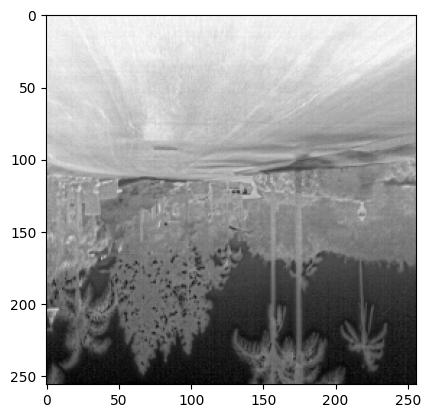

In [5]:
import matplotlib.pyplot as plt
plt.imshow(X_train[300])

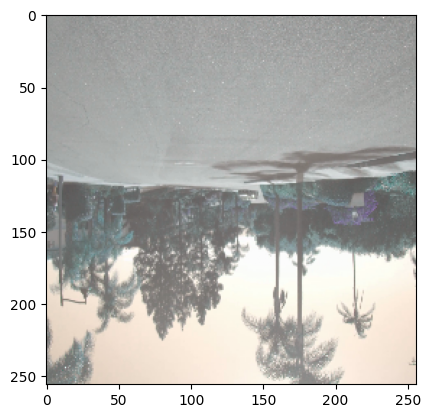

In [6]:
plt.imshow(y_train[300])

Epoch 1 - Generator Loss: 17.728044509887695, Discriminator Loss: 0.9748638272285461
Epoch 2 - Generator Loss: 15.662399291992188, Discriminator Loss: 0.9933708906173706
Epoch 3 - Generator Loss: 14.407403945922852, Discriminator Loss: 0.9726410508155823
Epoch 4 - Generator Loss: 13.970135688781738, Discriminator Loss: 0.9451371431350708
Epoch 5 - Generator Loss: 13.359512329101562, Discriminator Loss: 0.9176821112632751
Epoch 6 - Generator Loss: 12.834348678588867, Discriminator Loss: 0.9035726189613342
Epoch 7 - Generator Loss: 12.67512321472168, Discriminator Loss: 0.8912883996963501
Epoch 8 - Generator Loss: 12.351228713989258, Discriminator Loss: 0.9018797874450684
Epoch 9 - Generator Loss: 11.842914581298828, Discriminator Loss: 0.886176586151123
Epoch 10 - Generator Loss: 11.823636054992676, Discriminator Loss: 0.8737311363220215
Epoch 11 - Generator Loss: 11.519023895263672, Discriminator Loss: 0.8435043692588806
Epoch 12 - Generator Loss: 11.233471870422363, Discriminator Loss

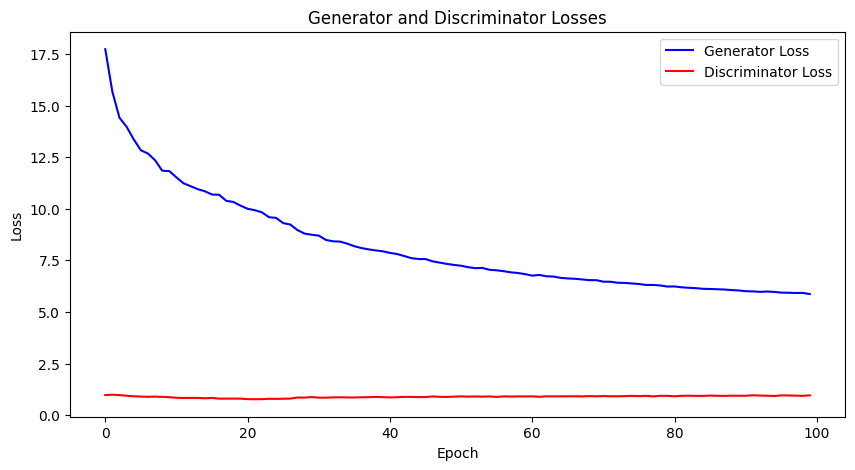

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import os

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def Generator():
    inputs = layers.Input(shape=(256, 256, 3))
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')
    x = inputs
    s = []
    concat = layers.Concatenate()
    for down in down_stack:
        x = down(x)
        s.append(x)
    s = reversed(s[:-1])
    for up, sk in zip(up_stack, s):
        x = up(x)
        x = concat([x, sk])
    x = last(x)
    return Model(inputs=inputs, outputs=x)

def Discriminator():
    ini = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    tar = layers.Input(shape=[256, 256, 3], name='target_image')

    x = layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=ini,
                         use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = layers.BatchNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=ini)(zero_pad2)  # (bs, 30, 30, 1)

    return Model(inputs=[inp, tar], outputs=last)

generator = Generator()
discriminator = Discriminator()

loss_object = BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (100 * l1_loss)

    return total_gen_loss

generator_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_optimizer = Adam(2e-4, beta_1=0.5)

checkpoint_dir = './training_checkpoints_flir_pix2pix'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)



# Define the number of epochs for training
EPOCHS = 100

# Lists to store losses
generator_losses = []
discriminator_losses = []

# Function to train the Pix2Pix model
def train(dataset, epochs):
    for epoch in range(epochs):
        epoch_gen_loss_avg = tf.keras.metrics.Mean()
        epoch_disc_loss_avg = tf.keras.metrics.Mean()
        for batch in dataset:
            gen_loss, disc_loss = train_step(batch)
            epoch_gen_loss_avg.update_state(gen_loss)
            epoch_disc_loss_avg.update_state(disc_loss)
        # Save the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        generator_losses.append(epoch_gen_loss_avg.result())
        discriminator_losses.append(epoch_disc_loss_avg.result())
        print('Epoch {} - Generator Loss: {}, Discriminator Loss: {}'.format(epoch + 1, epoch_gen_loss_avg.result(), epoch_disc_loss_avg.result()))

@tf.function
def train_step(batch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator(batch[0], training=True)

        # Calculate discriminator loss
        real_output = discriminator([batch[0], batch[1]], training=True)
        generated_output = discriminator([batch[0], generated_images], training=True)
        disc_loss = discriminator_loss(real_output, generated_output)

        # Calculate generator loss
        gen_loss = generator_loss(generated_output, generated_images, batch[1])

    # Calculate gradients and apply them using optimizers
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Prepare the dataset (X_train, y_train should be normalized between -1 and 1)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(1)

# Start training
train(train_dataset, EPOCHS)

# Plotting function
def plot_losses(generator_losses, discriminator_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(generator_losses, label='Generator Loss', color='blue')
    plt.plot(discriminator_losses, label='Discriminator Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Losses')
    plt.legend()
    plt.show()


# Plot losses
plot_losses(generator_losses, discriminator_losses)

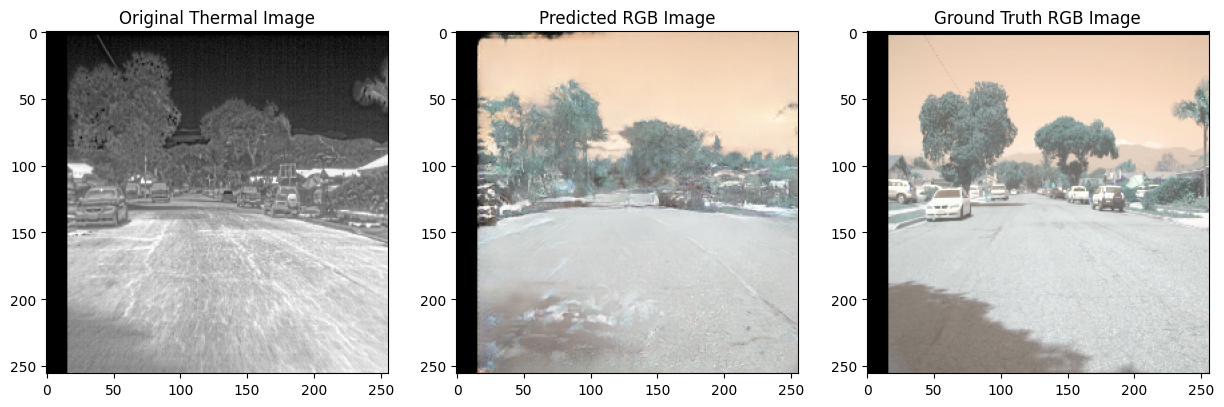

In [ ]:
import matplotlib.pyplot as plt

# Function to make predictions
def generate_images(model, test_input):
    prediction = model(test_input, training=True)
    return prediction

# Choose a sample thermal image for prediction
sample_index = 10  # Assuming you want to predict for the third image in the validation set
sample_thermal_image = X_val[sample_index:sample_index+1]
ground_truth_rgb_image = y_val[sample_index:sample_index+1]

# Generate RGB image predictions
predicted_rgb_image = generate_images(generator, sample_thermal_image)

# Plot the original thermal image, predicted RGB image, and ground truth RGB image
plt.figure(figsize=(15, 5))

# Plot original thermal image
plt.subplot(1, 3, 1)
plt.title('Original Thermal Image')
plt.imshow(sample_thermal_image[0])

# Plot predicted RGB image
plt.subplot(1, 3, 2)
plt.title('Predicted RGB Image')
plt.imshow(predicted_rgb_image[0])

# Plot ground truth RGB image
plt.subplot(1, 3, 3)
plt.title('Ground Truth RGB Image')
plt.imshow(ground_truth_rgb_image[0])

plt.show()


In [11]:
import matplotlib.pyplot as plt

# Function to make predictions
def generate_images(model, test_input):
    prediction = model(test_input, training=True)
    return prediction

# Choose sample indices for prediction
sample_indices = [8, 120, 102, 69]  # Assuming you want to predict for the 3rd, 6th, and 9th images in the validation set

plt.figure(figsize=(25, 15))

for i, sample_index in enumerate(sample_indices):
    # Choose a sample thermal image and ground truth RGB image for prediction
    sample_thermal_image = X_val[sample_index:sample_index+1]
    ground_truth_rgb_image = y_val[sample_index:sample_index+1]

    # Generate RGB image predictions
    predicted_rgb_image = generate_images(generator, sample_thermal_image)

    # Plot the original thermal image, predicted RGB image, and ground truth RGB image
    plt.subplot(len(sample_indices), 3, i*3 + 1)
    plt.title('Original Thermal Image {}'.format(i+1))
    plt.imshow(sample_thermal_image[0])

    plt.subplot(len(sample_indices), 3, i*3 + 2)
    plt.title('Predicted RGB Image {}'.format(i+1))
    plt.imshow(predicted_rgb_image[0])

    plt.subplot(len(sample_indices), 3, i*3 + 3)
    plt.title('Ground Truth RGB Image {}'.format(i+1))
    plt.imshow(ground_truth_rgb_image[0])

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import matplotlib.pyplot as plt

# Function to make predictions
def generate_images(model, test_input):
    prediction = model(test_input, training=True)
    return prediction

# Choose sample indices for prediction
sample_indices = [2, 5, 8]  # Assuming you want to predict for the 3rd, 6th, and 9th images in the validation set

plt.figure(figsize=(25, 15))

for i, sample_index in enumerate(sample_indices):
    # Choose a sample image from X_val
    sample_image = X_val[sample_index:sample_index+1]

    # Generate RGB image prediction
    predicted_rgb_image = generate_images(generator, sample_image)

    # Plot the original thermal image and predicted RGB image
    plt.subplot(3, 2, i*2 + 1)
    plt.title('Original Image {}'.format(i+1))
    plt.imshow(sample_image[0])

    plt.subplot(3, 2, i*2 + 2)
    plt.title('Predicted RGB Image {}'.format(i+1))
    plt.imshow(predicted_rgb_image[0])

plt.tight_layout()
plt.show()
